In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc, os


from sklearn.neighbors import KNeighborsClassifier
#import metrics model to check the accuracy 
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [2]:
q2_stations0 = pd.read_csv("C:/DPA Project/chunk0.csv")
q2_stations1 = pd.read_csv("C:/DPA Project/chunk1.csv")
q2_stations2 = pd.read_csv("C:/DPA Project/chunk2.csv")
q2_stations3 = pd.read_csv("C:/DPA Project/chunk3.csv")
q2_stations4 = pd.read_csv("C:/DPA Project/chunk4.csv")
q2_stations5 = pd.read_csv("C:/DPA Project/chunk5.csv")
q2_stations6 = pd.read_csv("C:/DPA Project/chunk6.csv")
q2_stations7 = pd.read_csv("C:/DPA Project/chunk7.csv")
q2_stations8 = pd.read_csv("C:/DPA Project/chunk8.csv")
q2_stations9 = pd.read_csv("C:/DPA Project/chunk9.csv")

In [3]:
## Concatenate all 3 years of data
q2_stations = pd.concat([q2_stations0, q2_stations1, q2_stations2, q2_stations3,q2_stations4, q2_stations5, q2_stations6, q2_stations7, q2_stations8,q2_stations9])

In [4]:
q2_stations['tripduration'] = q2_stations['tripduration']/60

In [5]:
q2_stations = q2_stations[q2_stations['tripduration'] < 50]  

In [6]:
q2_stations = q2_stations.dropna()

In [9]:
## Convert the 'start_time' column to a datetime object
q2_stations['start_time'] = pd.to_datetime(q2_stations['start_time'])

In [10]:
split_date = pd.datetime(2018,12,31)
df_train = q2_stations.loc[q2_stations['start_time'] <= split_date]
df_train['trips_per_day'] = df_train.trips / 365
df_test = q2_stations.loc[q2_stations['start_time'] > split_date]
df_test['trips_per_day'] = df_test.trips / 365

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


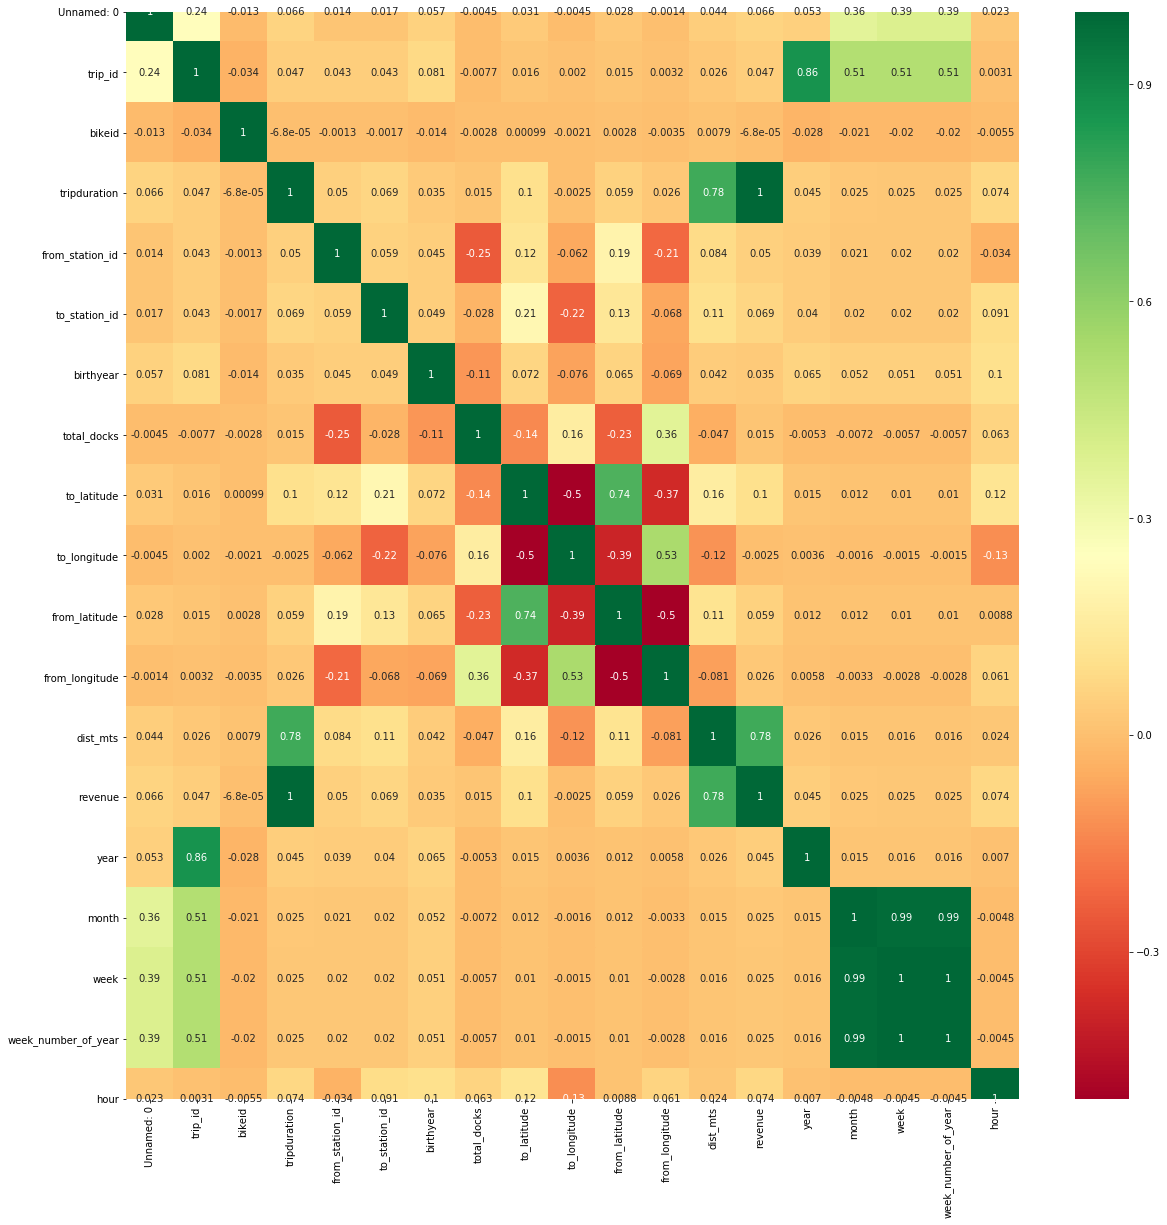

In [13]:
#get correlations of each features in dataset
corrmat = q2_stations.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(q2_stations[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
INDICATOR = 'total_docks'
features = ['tripduration', 'to_station_id','to_longitude','from_longitude','revenue','hour']
X_train = df_train[features]
y_train = df_train[INDICATOR]
X_test = df_test[features]
y_test = df_test[INDICATOR]

In [47]:
error_rate = []
# Will take some time
for i in range(1,20):
 
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

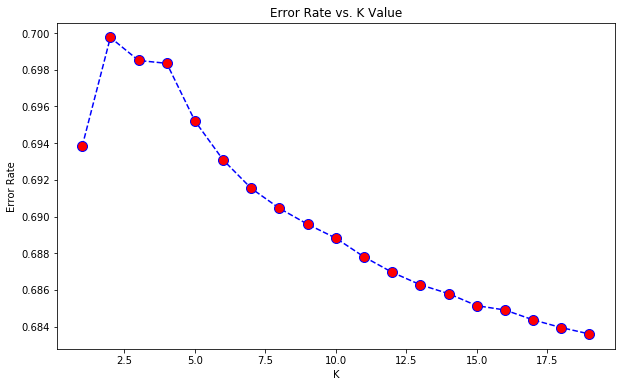

In [48]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color= 'blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [49]:
# NOW WITH K=3
knn = KNeighborsClassifier(n_neighbors=2)

In [50]:
knn.fit(X_train,y_train)
pred = knn.predict(X_test)


In [51]:
scores = metrics.accuracy_score(y_test,pred)
scores

0.3002359186851256

In [59]:
import pickle
filename = 'C:/DPA Project/knn_model.sav'
pickle.dump(knn, open(filename, 'wb'))

In [60]:
df_test["predicted_docks"] = pred

In [62]:
#Difference between existing and predicted docs

df_test["dock_diff"] = df_test["total_docks"] - df_test["predicted_docks"]

In [63]:
df_test['abs_dock_diff'] = df_test['dock_diff'].abs()

In [64]:
df_test1 = df_test.sort_values('abs_dock_diff', ascending=False).drop_duplicates(['from_station_id'])

In [65]:
#Assuming each dock setup in a station costs $400
m = df_test1.groupby(['from_station_id']).agg({'dock_diff':sum})

In [66]:
#Cost of setting up all the extra docks assuming each single dock costs company $400

m['cost'] = m['dock_diff']*400

In [67]:
total = m['cost'].sum()
total

-6355600.0

In [69]:
station_data = pd.read_csv("C:/DPA Project/data/Divvy_Bicycle_Stations.csv")

In [70]:
m = pd.concat([station_data,m],axis = 1, join = 'inner',join_axes = [station_data.ID])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  """Entry point for launching an IPython kernel.


In [71]:
m = m[['Station Name','dock_diff','cost']]

In [72]:
m['cost'] = m['cost'].apply(lambda x: "${:.1f}k".format((x/1000)))

In [75]:
m.head(10)

,Station Name,dock_diff,cost
ID,,,
418,Carpenter St & 63rd St,-44.0,$-17.6k
249,Claremont Ave & Hirsch St,-24.0,$-9.6k
322,Clark St & Elm St,-36.0,$-14.4k
168,Pulaski Rd & Lake St,-36.0,$-14.4k
316,Racine Ave & Congress Pkwy,-36.0,$-14.4k
537,Ogden Ave & Roosevelt Rd,-20.0,$-8.0k
300,Clark St & 9th St (AMLI),-36.0,$-14.4k
75,Austin Blvd & Chicago Ave,36.0,$14.4k
480,Clark St & Touhy Ave,-36.0,$-14.4k
